# Airbnb and Zillow Data challenge
The objective of this challenge is to determine the best location(Zip) to invest in New York city for a real estate company.<br>
Basic assumptions for this process are:<br>
### Given Assumptions:
> - The investor will pay for the property in cash
> - The value of money will not change
> - All properties and all square feet within each locale can be assumed to be homogeneous
> - Occupancy rate id 75% for the year

### Additional Assumptions:
> - The capital to be invested is not constrained
> - Each Zip follows the same growth trend year over year

## The basic process flow

##  Importing required libraries

In [1]:
import itertools
import warnings

import math  
import numpy as np
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly as py
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
import cufflinks as cf

cf.set_config_file(offline=True, world_readable=True, theme='solar')
init_notebook_mode(connected=True)
warnings.filterwarnings("ignore")

ModuleNotFoundError: No module named 'plotly'

## Defining the required parameters
We are defining parametes so that the analysis can be easily replicated for other criterias if the valid data sets are available

- Defineing the location of the file and the filter conditions
> Input zillow file and Airbnb file  along with the location<br>
> City and State as New York and NY as specified in the problem statement <br>
> Occupancy rate is considered as 75% constant irresective of the zipcode location <br>
> As we are concered of individual 2 bedroom appartment we specify the same in the room type and the number of rooms <br>
> more that 50 percentile of the housed in airbnb has the minimum stay perid as 2 day,so we consider the length of stay as 2 <br>

- Reading the initial dataset
> Read in compressed Airbnb data set and the zillow data from the file location as pandas dataframe for cleaning and analysis


In [2]:
airbnb_dataset_location = 'Dataset/listings.csv.gz'
zillow_dataset_location = 'Dataset/Zip_Zhvi_2bedroom.csv'

city = 'New York'
state = 'NY'
room_type = 'Entire home/apt'

bedroom = int(2)
months_to_forecast = int(18)
stay_length = int(2)
occupancy_rate = float(0.75)

In [3]:
def read_file(file,compression = 'infer',sep=','):
    return pd.read_table(file, compression=compression,sep=sep,low_memory=False)

In [4]:
Airbnb = read_file(airbnb_dataset_location,'gzip')
Zillow = read_file(zillow_dataset_location)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: read_table is deprecated, use read_csv instead.
  


FileNotFoundError: [Errno 2] No such file or directory: 'Dataset/listings.csv.gz'

## Zillow Data Preparation
Zillow porvides the price history for the 2 bedroom houses in various zip by time period (yyyy-mm).<br>
The initial step in cleaning this data is to subset the Zillow dataset by city (NYC) and state(NY)<br>
To determine the sanity of the dataset we visulize the price variation over the time-period by zipcode<br>

In [9]:
Zillow_selected = Zillow[(Zillow.State == state) & (Zillow.City == city)]
Zillow_selected.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06
0,61639,10025,New York,NY,New York,New York,1,NaN,NaN,NaN,...,1374400,1364100,1366300,1354800.0,1327500,1317300,1333700,1352100,1390000,1431000
2,61637,10023,New York,NY,New York,New York,3,NaN,NaN,NaN,...,1993500,1980700,1960900,1951300.0,1937800,1929800,1955000,2022400,2095000,2142300
13,61703,10128,New York,NY,New York,New York,14,NaN,NaN,NaN,...,1526000,1523700,1527200,1541600.0,1557800,1582900,1598900,1646100,1720500,1787100
14,61625,10011,New York,NY,New York,New York,15,NaN,NaN,NaN,...,2354000,2355500,2352200,2332100.0,2313300,2319600,2342100,2365900,2419700,2480400
20,61617,10003,New York,NY,New York,New York,21,NaN,NaN,NaN,...,1932800,1930400,1937500,1935100.0,1915700,1916500,1965700,2045300,2109100,2147000


In [10]:
Zillow_selected.describe()

,RegionID,RegionName,SizeRank,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,...,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06
count,25.00000,25.000000,25.000000,8.000000,8.000000,8.000000,8.000000,8.00000,8.000000,8.00000,...,2.500000e+01,2.500000e+01,2.500000e+01,2.500000e+01,2.500000e+01,2.500000e+01,2.500000e+01,2.500000e+01,2.500000e+01,2.500000e+01
mean,61783.16000,10412.680000,1044.880000,130187.500000,129462.500000,128625.000000,128012.500000,127462.50000,127050.000000,126625.00000,...,1.203912e+06,1.201388e+06,1.201064e+06,1.202428e+06,1.200756e+06,1.203356e+06,1.216940e+06,1.241344e+06,1.268768e+06,1.289684e+06
std,164.60728,500.615348,1365.959502,17465.920899,16294.252931,15410.362933,14317.764939,13447.35104,13156.747318,13132.91938,...,8.564769e+05,8.468969e+05,8.387594e+05,8.353629e+05,8.299341e+05,8.237741e+05,8.281351e+05,8.452168e+05,8.665523e+05,8.825707e+05
min,61617.00000,10003.000000,1.000000,99200.000000,102000.000000,103900.000000,105400.000000,106900.00000,107800.000000,107900.00000,...,2.845000e+05,2.871000e+05,2.907000e+05,2.947000e+05,2.990000e+05,3.038000e+05,3.083000e+05,3.138000e+05,3.213000e+05,3.277000e+05
25%,61637.00000,10023.000000,52.000000,121700.000000,121425.000000,120725.000000,120250.000000,119775.00000,119225.000000,118575.00000,...,3.483000e+05,3.511000e+05,3.561000e+05,3.584000e+05,3.605000e+05,3.649000e+05,3.711000e+05,3.772000e+05,3.837000e+05,3.905000e+05
50%,61780.00000,10304.000000,580.000000,130500.000000,130550.000000,130200.000000,130100.000000,130250.00000,130550.000000,130000.00000,...,1.207600e+06,1.209800e+06,1.216200e+06,1.221400e+06,1.225600e+06,1.225000e+06,1.219600e+06,1.238100e+06,1.276400e+06,1.302300e+06
75%,61790.00000,10314.000000,1744.000000,140975.000000,139725.000000,138625.000000,137075.000000,135425.00000,134175.000000,133850.00000,...,1.773200e+06,1.760600e+06,1.762000e+06,1.776800e+06,1.775200e+06,1.774500e+06,1.812700e+06,1.914600e+06,1.997800e+06,2.031600e+06
max,62120.00000,11434.000000,4647.000000,153000.000000,149800.000000,146900.000000,144800.000000,143100.00000,142300.000000,142400.00000,...,3.347100e+06,3.305500e+06,3.261100e+06,3.244000e+06,3.231400e+06,3.183300e+06,3.160200e+06,3.193500e+06,3.262200e+06,3.316500e+06


Visualizing the price cariation in the history for various zipcode

In [17]:
Zillow_selected.drop(columns= ["RegionID","City","State","Metro","CountyName","SizeRank"]).set_index('RegionName').T.iplot()

- We see some data inconstancy, so we neglect the time-period where the data is missing 
- We also remove the recession time-period as it’s not a seasonal effect it’s a once in a time effect if we use that then the prediction will be biased.
- It makes sense to convert the zip code (Region Name) from integers to strings as we cannot make computation on these value
- Just from the visualization standpoint we split the time series into year and month

In [18]:
Zillow_selected_1 = pd.melt(Zillow_selected, id_vars=['RegionName'], value_vars=list(Zillow_selected.columns[7:]))
Zillow_selected_1['Date'] = pd.to_datetime(Zillow_selected_1.variable)
Zillow_selected_1['Year'], Zillow_selected_1['Month'] = Zillow_selected_1['Date'].dt.year, Zillow_selected_1['Date'].dt.month
Zillow_selected_1['Zipcode'] = Zillow_selected_1['RegionName'].astype(str)
Zillow_selected_1 = Zillow_selected_1[['Zipcode','Date','Year','Month','value']]
Zillow_selected_1 =Zillow_selected_1[Zillow_selected_1.Date >= '2010-01-01']

This will be the cleaned price history that will be used to predict the 2018 price 

In [19]:
Zillow_selected_1.pivot(index='Date', columns='Zipcode', values='value').iplot()

In [20]:
Zillow_selected_arima = Zillow_selected_1.pivot(index='Date', columns='Zipcode', values='value').resample('M',convention='start').sum()

In [21]:
Zillow_selected_arima.head()

Zipcode,10003,10011,10013,10014,10021,10022,10023,10025,10028,10036,...,10308,10309,10312,10314,11201,11215,11217,11231,11234,11434
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-31,1227800.0,1378600.0,2268700.0,1451800.0,1163900.0,1323000.0,1271900.0,813300.0,1126000.0,1238600.0,...,323400.0,320000.0,296200.0,288700.0,742800.0,529300.0,619000.0,591300.0,378700.0,315400.0
2010-02-28,1202600.0,1372300.0,2294100.0,1454400.0,1176400.0,1338500.0,1252300.0,821500.0,1107300.0,1227700.0,...,324900.0,320000.0,296400.0,290800.0,747500.0,544800.0,619300.0,589600.0,386600.0,320300.0
2010-03-31,1207100.0,1393100.0,2273600.0,1494500.0,1184500.0,1344600.0,1262300.0,831700.0,1116100.0,1230700.0,...,325000.0,317400.0,296900.0,290200.0,750300.0,540900.0,612700.0,589500.0,391600.0,315800.0
2010-04-30,1220100.0,1430000.0,2261700.0,1542200.0,1192700.0,1348300.0,1279200.0,845100.0,1138500.0,1237300.0,...,326000.0,314900.0,296700.0,289200.0,753800.0,538300.0,612800.0,589300.0,392900.0,314000.0
2010-05-31,1252400.0,1462100.0,2282800.0,1587300.0,1203100.0,1350800.0,1309000.0,854500.0,1175900.0,1250400.0,...,324700.0,313100.0,295100.0,287000.0,758900.0,536800.0,614500.0,590900.0,392900.0,311800.0


## Prediction model
- We Are defining the Arima function to predict the future price of houses in each zip code based on the time series data<br>
- Visualizations have been commented out after initial implementation of the algorithm to make the model run faster <br>
- After we define the model, we run it to predict the future price of the houses by zip and appended it to the original dataset for further analysis

In [22]:
def each_zip(zipcode):
    data1 = Zillow_selected_arima[[zipcode]]
    train, test = data1[:'2016-12-01'], data1['2017-01-01':]
    result = seasonal_decompose(data1, model='Multiplicative')
    #fig = result.plot()
    p = d = q = range(0, 2)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
    P,Q,R=[],[],[]
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(data1,order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
                results = mod.fit()
                P.append(param)
                Q.append(param_seasonal)
                R.append(results.aic)
                #print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
            except:
                continue
    df = pd.DataFrame(data={'P': P, 'Q': Q, 'r': R})
    P_value = df[df.r == df.r.min()].P.values[0]
    Q_value = df[df.r == df.r.min()].Q.values[0]
    mod = sm.tsa.statespace.SARIMAX(data1,order=P_value,seasonal_order=Q_value,enforce_stationarity=False,enforce_invertibility=False)
    results = mod.fit()
    #print(results.summary().tables[1])
    #results.plot_diagnostics(figsize=(16, 8))
    #plt.show()
    #pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
    #pred_ci = pred.conf_int()
    #ax = data1['2010':].plot(label='observed')
    #pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
    #ax.fill_between(pred_ci.index,pred_ci.iloc[:, 0],pred_ci.iloc[:, 1], color='k', alpha=.2)
    #ax.set_xlabel('Date')
    #ax.set_ylabel('Sales')
    #plt.legend()
    #plt.show()
    pred_uc = results.get_forecast(steps=18)
    pred_ci = pred_uc.conf_int()
    #ax = data1.plot(label='observed', figsize=(14, 7))
    #pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
    #ax.fill_between(pred_ci.index,pred_ci.iloc[:, 0],pred_ci.iloc[:, 1], color='k', alpha=.25)
    #ax.set_xlabel('Date')
    #ax.set_ylabel('Furniture Sales')
    #plt.legend()
    #plt.show()
    data2 = pd.concat([data1, pred_uc.predicted_mean])
    data2.loc[data2[zipcode].isnull(),zipcode] = data2[0]
    del data2[0]
    return data2

In [23]:
for K,V in enumerate(Zillow_selected_arima.columns):
    print(str(K+1) + " : " + V)
    if K == 0:
        df = each_zip(V)
    else:
        df2 = each_zip(V)
        df = df.join(df2, how='outer')

1 : 10003
2 : 10011
3 : 10013
4 : 10014
5 : 10021
6 : 10022
7 : 10023
8 : 10025
9 : 10028
10 : 10036
11 : 10128
12 : 10303
13 : 10304
14 : 10305
15 : 10306
16 : 10308
17 : 10309
18 : 10312
19 : 10314
20 : 11201
21 : 11215
22 : 11217
23 : 11231
24 : 11234
25 : 11434


Visualizing the predicted price for each zip code

In [24]:
#df.plot(legend = None,figsize=(16, 8))
#plt.show()
df.iplot()

As we are concerned on the year over year change as that will be a part of our decision making we calculate that criteria.

In [25]:
Zillow_df = df.T
Zillow_df['YoY_change'] = df.T.iloc[:,-1] - df.T.iloc[:,-13]
Zillow_df['YoY_Percentage'] = Zillow_df.YoY_change*100 / df.T.iloc[:,-13]
Zillow_df.head()

,2010-01-31 00:00:00,2010-02-28 00:00:00,2010-03-31 00:00:00,2010-04-30 00:00:00,2010-05-31 00:00:00,2010-06-30 00:00:00,2010-07-31 00:00:00,2010-08-31 00:00:00,2010-09-30 00:00:00,2010-10-31 00:00:00,...,2018-05-31 00:00:00,2018-06-30 00:00:00,2018-07-31 00:00:00,2018-08-31 00:00:00,2018-09-30 00:00:00,2018-10-31 00:00:00,2018-11-30 00:00:00,2018-12-31 00:00:00,YoY_change,YoY_Percentage
10003,1227800.0,1202600.0,1207100.0,1220100.0,1252400.0,1285700.0,1278300.0,1279100.0,1326700.0,1376500.0,...,2.324884e+06,2.348626e+06,2.382052e+06,2.399643e+06,2.394674e+06,2.394661e+06,2.402744e+06,2.404117e+06,165568.780786,7.396257
10011,1378600.0,1372300.0,1393100.0,1430000.0,1462100.0,1476800.0,1479000.0,1476600.0,1461200.0,1448300.0,...,2.703867e+06,2.738285e+06,2.777323e+06,2.816253e+06,2.839061e+06,2.847162e+06,2.849671e+06,2.845056e+06,215080.687066,8.178049
10013,2268700.0,2294100.0,2273600.0,2261700.0,2282800.0,2288000.0,2275700.0,2281300.0,2302800.0,2290900.0,...,3.324877e+06,3.378988e+06,3.413921e+06,3.461261e+06,3.469548e+06,3.429180e+06,3.385464e+06,3.368706e+06,62433.997199,1.888350
10014,1451800.0,1454400.0,1494500.0,1542200.0,1587300.0,1616000.0,1612300.0,1605800.0,1592500.0,1584200.0,...,2.521083e+06,2.528651e+06,2.555575e+06,2.579681e+06,2.575340e+06,2.545287e+06,2.534568e+06,2.552854e+06,62608.576282,2.514153
10021,1163900.0,1176400.0,1184500.0,1192700.0,1203100.0,1203500.0,1200400.0,1202900.0,1210100.0,1210300.0,...,1.999370e+06,2.041381e+06,2.073718e+06,2.100034e+06,2.113973e+06,2.111908e+06,2.107505e+06,2.104850e+06,226294.421766,12.046194


In [26]:
Zillow_df.to_csv('Clean_DataSet/Zillow.csv')

## Airbnb Data Preparation
- Filtering the airbnb data set based on the zips available in the zillow dataset, number of rooms, and apartment type(entire house only) <br>
- We standardize the price format to float from string by removing unnecessary formatting characters for the ease of computation <br>
- As there are outliers in the price we retain the listings that have rent less than $500 so that they are distributed normally. <br>


In [27]:
Airbnb_selected = Airbnb[(Airbnb.zipcode.isin(Zillow_df.index.tolist())) & (Airbnb.bedrooms ==bedroom) & (Airbnb.room_type == room_type)].set_index('id')

In [28]:
Airbnb_selected.price= Airbnb_selected.price.replace('[\$,]', '', regex=True).astype(float)
Airbnb_selected.weekly_price= Airbnb_selected.weekly_price.replace('[\$,]', '', regex=True).astype(float)
Airbnb_selected.monthly_price= Airbnb_selected.monthly_price.replace('[\$,]', '', regex=True).astype(float)
Airbnb_selected.cleaning_fee= Airbnb_selected.cleaning_fee.replace('[\$,]', '', regex=True).astype(float)
Airbnb_selected.price = Airbnb_selected.price[Airbnb_selected.price < 500]

In [29]:
Airbnb_selected.price.iplot(kind = 'histogram',bins=50)

visualizing the number of listings in each zip codes

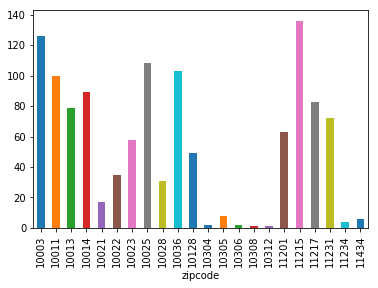

In [30]:
#Airbnb_selected = Airbnb_selected[['zipcode', 'market','smart_location','latitude', 'longitude','property_type', 'room_type','price', 'weekly_price', 'monthly_price','cleaning_fee','minimum_nights','maximum_nights','availability_30','availability_60','availability_90','availability_365']]
#df.groupby(['col1', 'col2']).size()

Airbnb_selected.groupby(['zipcode'], axis=0).count().listing_url.plot(kind = 'bar')

checking the standard statistics of the dataset

In [31]:
Airbnb_selected.describe()

,scrape_id,host_id,host_acceptance_rate,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,...,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,calculated_host_listings_count,reviews_per_month
count,1.173000e+03,1.173000e+03,0.0,1171.000000,1171.000000,1173.000000,1173.000000,1173.000000,1168.000000,1173.0,...,924.000000,923.000000,924.000000,921.000000,924.000000,921.000000,921.000000,0.0,1173.000000,938.000000
mean,2.017050e+13,2.791907e+07,NaN,2.269001,2.269001,40.728588,-73.985348,4.603581,1.245719,2.0,...,93.140693,9.516793,9.221861,9.711183,9.714286,9.737242,9.309446,NaN,1.305200,1.271226
std,0.000000e+00,3.133356e+07,NaN,25.014291,25.014291,0.044812,0.024993,1.307195,0.431691,0.0,...,8.021485,0.796201,1.071404,0.633464,0.721569,0.550111,0.837185,NaN,0.905396,1.369504
min,2.017050e+13,1.148100e+04,NaN,0.000000,0.000000,40.546331,-74.183701,2.000000,1.000000,2.0,...,20.000000,4.000000,2.000000,4.000000,2.000000,6.000000,2.000000,NaN,1.000000,0.020000
25%,2.017050e+13,3.799076e+06,NaN,1.000000,1.000000,40.685704,-73.997328,4.000000,1.000000,2.0,...,90.000000,9.000000,9.000000,10.000000,10.000000,10.000000,9.000000,NaN,1.000000,0.212500
50%,2.017050e+13,1.545315e+07,NaN,1.000000,1.000000,40.732775,-73.988465,4.000000,1.000000,2.0,...,95.000000,10.000000,9.000000,10.000000,10.000000,10.000000,9.000000,NaN,1.000000,0.700000
75%,2.017050e+13,4.386567e+07,NaN,2.000000,2.000000,40.762064,-73.976939,6.000000,1.500000,2.0,...,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,NaN,1.000000,2.000000
max,2.017050e+13,1.277347e+08,NaN,855.000000,855.000000,40.807344,-73.769800,10.000000,3.500000,2.0,...,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,NaN,12.000000,8.850000


- As the few listings has missing cleaning price it makes sense to take the average value of the cleaning price in the same region <br>
- At the same time few listing have missing weekly and monthly price so we fill with daily price for 7 and 30 days respectively

In [32]:
Mean_cleaning = Airbnb_selected[Airbnb_selected.cleaning_fee.notnull()].groupby(['zipcode'], axis=0).mean()['cleaning_fee']
Mean_cleaning = Mean_cleaning.to_frame().rename(index=str, columns={"cleaning_fee": "mean_cleaning_fee"})
Airbnb_selected = Airbnb_selected.merge(Mean_cleaning,on = 'zipcode')

In [33]:
Airbnb_selected.loc[Airbnb_selected.weekly_price.isnull(),'weekly_price'] = Airbnb_selected.price*7
Airbnb_selected.loc[Airbnb_selected.monthly_price.isnull(),'monthly_price'] = Airbnb_selected.price*30
Airbnb_selected.loc[Airbnb_selected.cleaning_fee.isnull(),'cleaning_fee'] = Airbnb_selected.mean_cleaning_fee
Airbnb_selected = Airbnb_selected.drop(columns = 'mean_cleaning_fee')

As there are multiple listings for each zip code we take the average values for each zip code <br>

In [34]:
Airbnb_cleaned_summary = Airbnb_selected.groupby(['zipcode'], axis=0).mean()
Airbnb_cleaned_summary.head()

,scrape_id,host_id,host_acceptance_rate,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,...,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,calculated_host_listings_count,reviews_per_month
zipcode,,,,,,,,,,,,,,,,,,,,,
10003,2.017050e+13,2.579635e+07,NaN,1.611111,1.611111,40.729916,-73.987951,4.626984,1.265873,2.0,...,92.100000,9.490000,9.160000,9.710000,9.680000,9.830000,9.320000,NaN,1.404762,1.341619
10011,2.017050e+13,3.084158e+07,NaN,1.420000,1.420000,40.741151,-73.999407,4.580000,1.338384,2.0,...,93.927711,9.506024,9.216867,9.807229,9.843373,9.891566,9.265060,NaN,1.180000,1.357831
10013,2.017050e+13,2.802596e+07,NaN,1.371795,1.371795,40.719407,-74.002547,4.430380,1.291139,2.0,...,91.534483,9.526316,9.103448,9.561404,9.413793,9.719298,9.245614,NaN,1.177215,1.571207
10014,2.017050e+13,1.962852e+07,NaN,1.573034,1.573034,40.734523,-74.004059,4.505618,1.191011,2.0,...,93.216216,9.608108,9.283784,9.671233,9.756757,9.945205,9.205479,NaN,1.258427,1.110000
10021,2.017050e+13,3.301360e+07,NaN,1.588235,1.588235,40.768344,-73.956700,4.529412,1.058824,2.0,...,92.230769,9.615385,8.923077,9.615385,9.615385,9.384615,9.307692,NaN,1.294118,1.163077


- Calculating the revenue earned by renting out for every day, minimum stay time, weekly and monthly<br>
- Assuming the occupancy rate is constant through the year<br>

In [37]:
Rent_df = Airbnb_cleaned_summary
days_occupied = int(365*occupancy_rate)
Rent_df['Everyday_rent'] = (Rent_df.price * days_occupied ) - (days_occupied*Rent_df.cleaning_fee)
Rent_df['Daily_rent'] = (Rent_df.price * days_occupied) - ((days_occupied/stay_length)*Rent_df.cleaning_fee)
Rent_df['Weekly_rent'] = (Rent_df.weekly_price * (days_occupied/7)) - ((days_occupied/7)*Rent_df.cleaning_fee)
Rent_df['Monthly_rent'] = (Rent_df.monthly_price * (days_occupied/30)) - ((days_occupied/30)*Rent_df.cleaning_fee)
Rent_df.head()

,scrape_id,host_id,host_acceptance_rate,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,...,review_scores_communication,review_scores_location,review_scores_value,license,calculated_host_listings_count,reviews_per_month,Everyday_rent,Daily_rent,Weekly_rent,Monthly_rent
zipcode,,,,,,,,,,,,,,,,,,,,,
10003,2.017050e+13,2.579635e+07,NaN,1.611111,1.611111,40.729916,-73.987951,4.626984,1.265873,2.0,...,9.680000,9.830000,9.320000,NaN,1.404762,1.341619,45221.970652,58679.033152,68915.340517,70160.562500
10011,2.017050e+13,3.084158e+07,NaN,1.420000,1.420000,40.741151,-73.999407,4.580000,1.338384,2.0,...,9.843373,9.891566,9.265060,NaN,1.180000,1.357831,49104.370370,64229.870370,78349.142857,75792.636992
10013,2.017050e+13,2.802596e+07,NaN,1.371795,1.371795,40.719407,-74.002547,4.430380,1.291139,2.0,...,9.413793,9.719298,9.245614,NaN,1.177215,1.571207,49198.256250,63318.206250,77571.815528,74936.951818
10014,2.017050e+13,1.962852e+07,NaN,1.573034,1.573034,40.734523,-74.004059,4.505618,1.191011,2.0,...,9.756757,9.945205,9.205479,NaN,1.258427,1.110000,50682.311285,64361.149314,72788.673063,74939.386107
10021,2.017050e+13,3.301360e+07,NaN,1.588235,1.588235,40.768344,-73.956700,4.529412,1.058824,2.0,...,9.615385,9.384615,9.307692,NaN,1.294118,1.163077,39124.312500,48849.937500,55796.812500,56789.687500


In [38]:
Rent_df.to_csv('Clean_DataSet/Airbnb.csv')

To determine the best zip code to invest, we are calculating the return on investment for each one of in the past one year
> return on investment = increase in the property cost and the rent earned

We cannot determine the number of days the property is rented by each person, so we take a combination of rent type to get the optimal rental cost<br>
Assuming the following percentage distribution:
> 30% for everyday rental <br>
> 40% for 2 days rental <br>
> 20% for weekly rental <br>
> 10% for monthly rental <br>

To compare the results, we convert the initial buying cost to percentage in terms of the maximum prize in any zip code and convert the ROI to percentage in terms of the maximum ROI in any zip code. as it makes it easier to compare the values

In [40]:
final_df = pd.merge(Rent_df, Zillow_df.iloc[:,[-15,-3,-2,-1]], left_index=True, right_index=True)
final_df['E_ROI'] = (final_df.Everyday_rent + final_df.YoY_change)*100/final_df.iloc[:,-4]
final_df['D_ROI'] = (final_df.Daily_rent + final_df.YoY_change)*100/final_df.iloc[:,-5]
final_df['W_ROI'] = (final_df.Weekly_rent + final_df.YoY_change)*100/final_df.iloc[:,-6]
final_df['M_ROI'] = (final_df.Monthly_rent + final_df.YoY_change)*100/final_df.iloc[:,-7]
final_df['optimal'] = (30*final_df.E_ROI + 40*final_df.D_ROI + 20*final_df.W_ROI + 10*final_df.M_ROI)/100
final_df['investment'] = final_df.iloc[:,-9]*100/final_df.iloc[:,-9].max()
final_df['ROI'] = (final_df.optimal*final_df.iloc[:,-10])*100/(final_df.optimal*final_df.iloc[:,-10]).max()
final_df['zipcode'] = final_df.index
final_df

,scrape_id,host_id,host_acceptance_rate,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,...,YoY_change,YoY_Percentage,E_ROI,D_ROI,W_ROI,M_ROI,optimal,investment,ROI,zipcode
10003,2.017050e+13,2.579635e+07,NaN,1.611111,1.611111,40.729916,-73.987951,4.626984,1.265873,2.0,...,165568.780786,7.396257,9.416404,10.017556,10.474830,10.530456,9.979955,67.706112,51.245457,10003
10011,2.017050e+13,3.084158e+07,NaN,1.420000,1.420000,40.741151,-73.999407,4.580000,1.338384,2.0,...,215080.687066,8.178049,10.045153,10.620272,11.157132,11.059925,10.599074,79.545043,63.941075,10011
10013,2.017050e+13,2.802596e+07,NaN,1.371795,1.371795,40.719407,-74.002547,4.430380,1.291139,2.0,...,62433.997199,1.888350,3.376378,3.803444,4.234552,4.154859,3.796687,100.000000,28.794116,10013
10014,2.017050e+13,1.962852e+07,NaN,1.573034,1.573034,40.734523,-74.004059,4.505618,1.191011,2.0,...,62608.576282,2.514153,4.549387,5.098683,5.437105,5.523470,5.044057,75.318828,28.812602,10014
10021,2.017050e+13,3.301360e+07,NaN,1.588235,1.588235,40.768344,-73.956700,4.529412,1.058824,2.0,...,226294.421766,12.046194,14.128875,14.646593,15.016392,15.069245,14.607503,56.817931,62.944863,10021
10022,2.017050e+13,3.903324e+07,NaN,1.371429,1.371429,40.759036,-73.966817,5.571429,1.300000,2.0,...,292793.719054,14.194658,16.755759,17.405459,17.797151,17.937536,17.342095,62.387596,82.053804,10022
10023,2.017050e+13,3.111256e+07,NaN,3.000000,3.000000,40.777508,-73.981488,4.827586,1.379310,2.0,...,288678.703056,12.885015,14.938692,15.610336,16.341145,16.263905,15.620362,67.762785,80.275171,10023
10025,2.017050e+13,2.451314e+07,NaN,1.583333,1.583333,40.797944,-73.966412,4.944444,1.231481,2.0,...,99192.492072,6.820710,9.573601,10.460698,11.035657,11.129433,10.376434,43.985611,34.614469,10025
10028,2.017050e+13,3.654816e+07,NaN,1.387097,1.387097,40.775343,-73.950925,4.387097,1.266667,2.0,...,383956.979953,17.743179,19.545179,20.183971,20.671403,20.745633,20.145986,65.450439,100.000000,10028
10036,2.017050e+13,3.982620e+07,NaN,9.737864,9.737864,40.760145,-73.991623,5.126214,1.223301,2.0,...,133.314151,0.007980,3.063970,3.968438,4.741574,4.846748,3.939556,50.527172,15.096322,10036


In [41]:
final_df.iplot(kind='scatter',mode='markers', x='investment', y='ROI',text='zipcode',xTitle='% invested', yTitle='%ROI')

- From the above visualization we can say that investing in 10028 is much better as it would give the maximum profit by not spending a lot
- Below we visualize the zip code in the map

In [43]:
import plotly.plotly as py
plot_df = final_df.reset_index()
scl = [[0.0, 'rgb(242,240,247)'],[0.2, 'rgb(218,218,235)'],[0.4, 'rgb(188,189,220)'],[0.6, 'rgb(158,154,200)'],[0.8, 'rgb(117,107,177)'],[1.0, 'rgb(84,39,143)']]


In [44]:
data = [ dict(
        type = 'scattergeo',
        locationmode = 'country names',
        lon = plot_df['longitude'],
        lat = plot_df['latitude'],
        text = plot_df['zipcode'],
        mode = 'markers',
        marker = dict( 
            size = 8, 
            opacity = 0.8,
            autocolorscale = True,
            symbol = 'circle',
            line = dict(
                width=1,
                color='rgba(102, 102, 102)'
            ),
            colorscale = scl,
            cmin = plot_df['ROI'].min(),
            color =plot_df['ROI'],
            cmax = plot_df['ROI'].max(),
            colorbar=dict(
                title="ROI %"
            )
        ))]

In [45]:

layout = dict(
        title = 'Return on Investment',
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa',scale=1 ),
            showlakes = True,
            lakecolor = 'rgba(102, 102, 102)',
            lonaxis=dict(showgrid=True),
            showland=True,
            showocean=True,
            showcountries=True,
            showsubunits = True,
            resolution=50,            
        ),
    )

fig = dict(data=data, layout=layout)

iplot(fig)

In [46]:
final_df.to_csv('Clean_DataSet/Final.csv')

# Conclusion
Based on the above analysis 10028 is the most promising area to invest as it has the optimal cost of purchase and maximum ROI.<br><br>
<img src="optimal.PNG">

## Future State:
- As the number of zip codes were limited the analysis was restricted only to a small subset. More data could be collected to perform an extensive analysis <br>
- We can incorporate Crimes, Tourist and traffic data for analysis to give a more better and accurate result <br>
